# Exploring AirBnB in Europe

This notebook provides an analysis of Airbnb data for the following European cities:

- Amsterdam

- Athens

- Barcelona

- Berlin

- Copenhagen

- Dublin

- Lisbon

- London

- Madrid

- Paris

- Rome

- Venice

- Vienna

## Introduction

- Data was collected from [Inside Airbnb](http://insideairbnb.com), an open-source project that provides data and advocacy about Airbnb's impact on residential communities. 

- We used the data for the latest 12 months period for which data is available.

- In the `airbnb-listings/` directory, we have created a unique directory for each city, named as `<city-name>` (e.g., `amsterdam` for Amsterdam), with quarterly CSV files named as `<city-name>_1.csv`, `<city-name>_2.csv`, etc. (e.g., `amsterdam_1.csv`, `amsterdam_2.csv`). These files record Airbnb listings for each city across the quarters of the year.

## Setup Instructions

This notebook requires a few Python libraries for data analysis and visualization. If you don’t have them installed, run the code below in the first cell of the notebook:

In [1]:
%pip install pandas altair ipywidgets matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


- As a first step, we need to import the necessary libraries.

In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import altair as alt
import ipywidgets as widgets
from IPython.display import display

## Task 1: Airbnb Listings

- Our goal is to calculate the total number of unique Airbnb listings per city.
  
- We load all quarterly files for each city and combine them into one DataFrame.

- Then, we Use the listing `id` column to remove duplicates, counting each listing only once, and keeping it's latest entry.
  
- The output is a table displaying each city and its total unique listing count.


In [3]:
cities = ["Amsterdam", "Athens", "Barcelona", "Berlin", "Copenhagen",
          "Dublin", "Lisbon", "London", "Madrid", "Paris", "Rome",
          "Venice", "Vienna"]

# Directory containing all the city directories with quarterly CSVs
base_dir = "airbnb-listings/"

unique_listings_count = {}

all_data = pd.DataFrame()

for city in cities:
    city_dir = os.path.join(base_dir, city.lower())
    csv_files = glob.glob(f"{city_dir}/{city.lower()}_*.csv")  # Match all quarterly CSV files for the city

    # Load and concatenate all CSV files for the city
    city_data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

    # Add a 'City' column to identify each city's data in the master DataFrame
    city_data['City'] = city

    # Drop duplicates, keeping only the last occurrence of each 'id' (the latest entry)
    city_data_latest = city_data.drop_duplicates(subset='id', keep='last')

    # Count unique listings based on 'id' column
    unique_listings_count[city] = city_data_latest['id'].nunique()

    # Append to the master DataFrame
    all_data = pd.concat([all_data, city_data_latest], ignore_index=True)

listing_counts_df = pd.DataFrame(list(unique_listings_count.items()), columns=["City", "Number of Listings"])

print("Number of Unique Airbnb Listings per City (across all quarters):")
listing_counts_df

Number of Unique Airbnb Listings per City (across all quarters):


,City,Number of Listings
0,Amsterdam,11342
1,Athens,17112
2,Barcelona,24860
3,Berlin,15830
4,Copenhagen,24927
5,Dublin,12196
6,Lisbon,28914
7,London,129659
8,Madrid,35542
9,Paris,118804


- We also display the information as a bar plot for easy comparison.

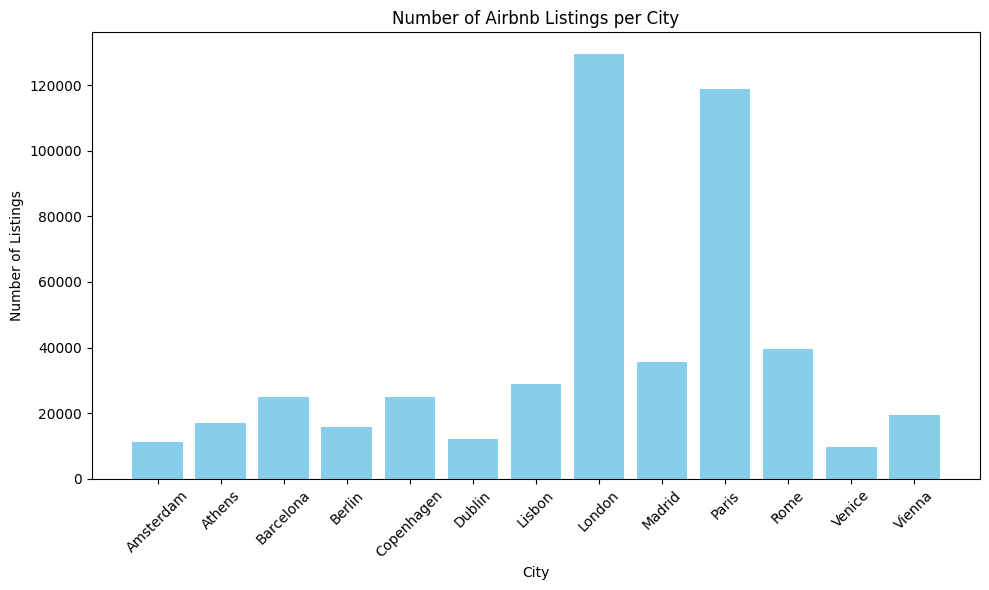

In [4]:
plt.figure(figsize=(10, 6))
plt.bar(listing_counts_df["City"], listing_counts_df["Number of Listings"], color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.title('Number of Airbnb Listings per City')
plt.xticks(rotation=45)
plt.tight_layout()

## Task 2: Airbnb Densities

We also want to calculate the number of Airbnb listings per 1,000 inhabitants, again for the latest 12 months period for which data is available. To calculate listing densities per city, we required detailed and reliable population data. Below is a streamlined overview of our data sources and processing steps.

### Data Sources

- **City Boundaries**: We used GeoJSON files from [Inside Airbnb](http://insideairbnb.com), which provide exact city boundary data. This helps ensure that both population and Airbnb data are aligned spatially.
  
- **Population Data**: High-resolution 2020 population data for each country was sourced from the [Humanitarian Data Exchange (HDX)](https://data.humdata.org/), managed by the UN, and originates from [WorldPop](https://hub.worldpop.org/). Specifically, we used `UN-adjusted` population data (`<country>_ppp_2020_UNadj.tif`), which is scaled to UN Population Division estimates for consistency and accuracy.

### Population Data Processing in QGIS

To extract accurate population figures within each city, we used [QGIS](https://www.qgis.org/) for geospatial processing:

1. **Load Data**: Each city’s GeoJSON boundary and the relevant population raster were imported into QGIS.
   
2. **Coordinate System Alignment**: We ensured all data used the same **Coordinate Reference System (CRS)** for accurate spatial calculations.

3. **Population Calculation**: Using QGIS’s Zonal Statistics tool, we calculated population within each city's boundary by overlaying the population raster and summing pixel values. This generated a reliable population estimate for each city.

### Data Quality

- **HDX**: The Humanitarian Data Exchange provides high-quality data from vetted sources, widely used in research and policy.
- **WorldPop**: WorldPop's datasets are trusted for high-resolution demographic data and are frequently used for international research and policy.


In [5]:
population_data_2020 = {
    "Amsterdam": 695_260,
    "Athens": 619_768,
    "Barcelona": 1_610_876,
    "Berlin": 3_482_284,
    "Copenhagen": 757_485,
    "Dublin": 1_374_171,
    "Lisbon": 2_231_652,
    "London": 9_241_042,
    "Madrid": 3_271_489,
    "Paris": 2_276_878,
    "Rome": 2_612_725,
    "Venice": 233_730,
    "Vienna": 1_917_187
}

### Refinement of Population Estimates Using World Bank Growth Data

To improve the accuracy of our population estimates, we refined our approach by applying recent annual growth rates to the 2020 population figures sourced from WorldPop. Although this approach is an estimate, it provides a practical method for reflecting recent demographic changes in the absence of precise city-level growth rates. Here’s how we structured this estimation:

- **World Bank Data on Annual Population Growth**:
  - We accessed publicly available data on annual population growth from the World Bank’s [World Development Indicators](https://data.worldbank.org/indicator), specifically the **Population growth (annual %)** metric. This dataset, derived from national censuses and validated by the World Bank, tracks yearly percentage changes in population for each country. 
  - We make the assumption that national trends generally correlate with urbanization and growth dynamics in metropolitan areas.

- **Methodology for Estimating 2024 Populations**:
  1. **Data Download**: We downloaded the World Bank’s growth data and stored it in the `population-growth-data/` directory. We renamed the main data file to `population_growth.csv`.
  2. **Cumulative Growth Calculation (2020–2024)**: Starting with each city’s 2020 population from WorldPop, we applied the annual growth rate iteratively to estimate the population in 2024. The formula used for this projection was:
     $$
     \text{Population}_{2024} = \text{Population}_{2020} \times (1 + \text{Growth Rate}_{2021}) \times (1 + \text{Growth Rate}_{2022}) \times (1 + \text{Growth Rate}_{2023}) \times (1 + \text{Growth Rate}_{2024})
     $$

     Since World Bank data is available only through 2023, we used the 2023 growth rate to estimate values for 2024.
     
     By applying each year’s growth rate successively, we generated a cumulative growth multiplier to produce reasonable population estimates for 2024.
  3. **Application to Cities**: Since the World Bank’s growth data is at the national level, these values provide an approximation. While urban growth rates can vary, this national-level growth multiplier aligns with demographic trends likely to impact metropolitan areas. For instance, national urbanization trends often mirror population increases in cities.

Although estimates are at the national level, this approach enables us to reflect recent growth trends as closely as possible in the absence of city-specific data, ensuring that Airbnb density metrics remain relevant to current (2024) population trends. While approximate, this adjustment enhances the relevance of our analysis.

In [6]:
# Country mappings for cities
city_country_map = {
    "Amsterdam": "Netherlands",
    "Athens": "Greece",
    "Barcelona": "Spain",
    "Berlin": "Germany",
    "Copenhagen": "Denmark",
    "Dublin": "Ireland",
    "Lisbon": "Portugal",
    "London": "United Kingdom",
    "Madrid": "Spain",
    "Paris": "France",
    "Rome": "Italy",
    "Venice": "Italy",
    "Vienna": "Austria"
}

growth_df = pd.read_csv("population-growth-data/population_growth.csv", skiprows=4)

# Filter relevant columns for 2021-2023 growth rates and rename them
growth_df = growth_df[["Country Name", "2021", "2022", "2023"]].rename(columns={"Country Name": "Country"})

# Convert growth rates from percentages to multipliers
for year in ["2021", "2022", "2023"]:
    growth_df[year] = growth_df[year].fillna(0) / 100

growth_df["2024"] = growth_df["2023"]

# Calculate cumulative growth multiplier for 2021-2024 for each country
growth_df["Cumulative Growth 2024"] = (
    (1 + growth_df["2021"]) *
    (1 + growth_df["2022"]) *
    (1 + growth_df["2023"]) *
    (1 + growth_df["2024"])
)

population_data_2024 = {}

# Calculate the 2024 population for each city based on its country's cumulative growth rate
for city, pop_2020 in population_data_2020.items():
    country = city_country_map[city]
    growth_multiplier = growth_df.loc[growth_df["Country"] == country, "Cumulative Growth 2024"].values[0]
    pop_2024 = int(pop_2020 * growth_multiplier)
    population_data_2024[city] = pop_2024

population_data_2024

{'Amsterdam': 719792,
 'Athens': 596326,
 'Barcelona': 1665332,
 'Berlin': 3566176,
 'Copenhagen': 778167,
 'Dublin': 1487465,
 'Lisbon': 2306115,
 'London': 9492222,
 'Madrid': 3382082,
 'Paris': 2303748,
 'Rome': 2575006,
 'Venice': 230355,
 'Vienna': 1982880}

- We present the information once more in a tabular format.

- Keep in mind that we count every Airbnb listing that was active at any point during the most recent 12-month period for which data is available, even if it was only active for a single month within that period.

In [7]:
population_df = pd.DataFrame(list(population_data_2024.items()), columns=["City", "Population"])
merged_df = pd.merge(listing_counts_df, population_df, on="City")
merged_df["Listings per 1,000 Inhabitants"] = (merged_df["Number of Listings"] / merged_df["Population"]) * 1000

print("Airbnb Listings Density per City (Listings per 1,000 Inhabitants):")
merged_df

Airbnb Listings Density per City (Listings per 1,000 Inhabitants):


,City,Number of Listings,Population,"Listings per 1,000 Inhabitants"
0,Amsterdam,11342,719792,15.757330
1,Athens,17112,596326,28.695713
2,Barcelona,24860,1665332,14.927954
3,Berlin,15830,3566176,4.438928
4,Copenhagen,24927,778167,32.032970
5,Dublin,12196,1487465,8.199185
6,Lisbon,28914,2306115,12.537970
7,London,129659,9492222,13.659499
8,Madrid,35542,3382082,10.508911
9,Paris,118804,2303748,51.569877


- We also visualize the findings in a bar plot.

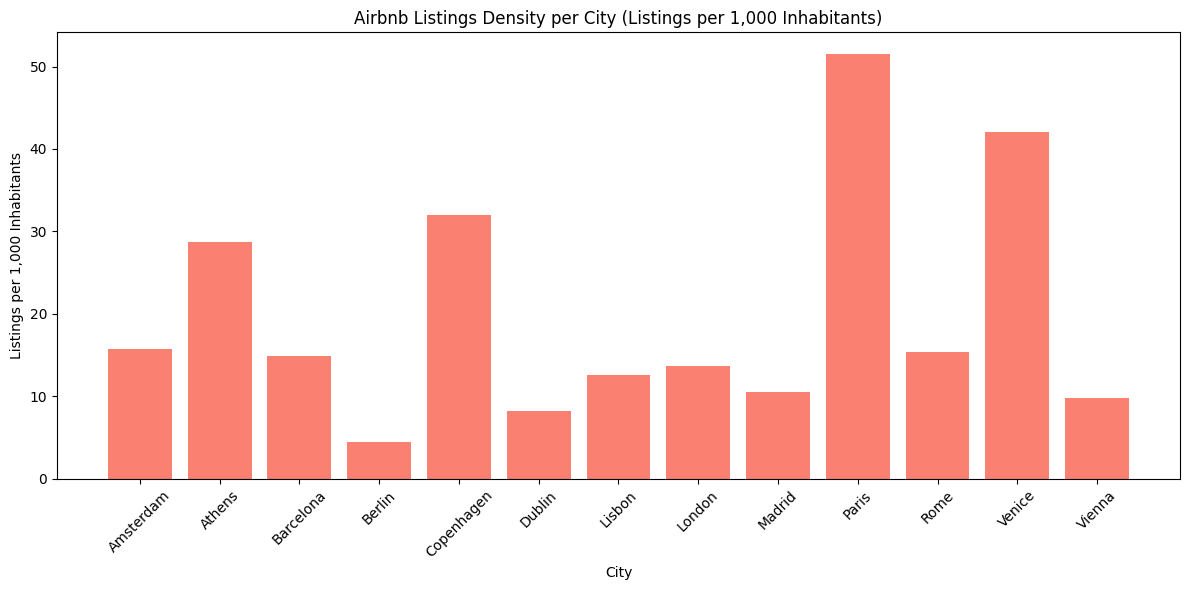

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(merged_df["City"], merged_df["Listings per 1,000 Inhabitants"], color='salmon')
plt.xlabel('City')
plt.ylabel('Listings per 1,000 Inhabitants')
plt.title('Airbnb Listings Density per City (Listings per 1,000 Inhabitants)')
plt.xticks(rotation=45)
plt.tight_layout()

## Task 3: Activity

Our goal is to estimate the average number of nights booked and income per Airbnb listing in each city:

- We estimate the average number of nights booked by assuming each booking lasts **3 nights** and **half of the bookings** receive a review. The formula used is:  

$$ \text{Estimated Nights Booked} = 3 \times (2 \times \text{Number of Reviews LTM}) $$  

- To avoid exceeding 365 nights, we cap the estimate at **365**.

- Income is calculated by multiplying the price per night by the estimated nights booked:  

$$ \text{Estimated Income} = \text{Price per Night} \times \text{Estimated Nights Booked} $$

For missing price data, we fill in `NaN` values with the **average price** for listings in the same city. To standardize income, we convert prices to **EUR** using exchange rates:  
- **1.0** for Eurozone cities  
- **1.20** for London (GBP to EUR)  
- **0.13** for Copenhagen (DKK to EUR)

Finally, we group the listings by city and calculate the average number of nights booked and the average income per listing.

In [9]:
# Fill NaN values in 'price' column with the mean price of the corresponding city
all_data['price'] = all_data.groupby('City')['price'].transform(lambda x: x.fillna(x.mean()))

exchange_rates = {
    "Amsterdam": 1.0,
    "Athens": 1.0,
    "Barcelona": 1.0,
    "Berlin": 1.0,
    "Copenhagen": 0.13, # Denmark uses DKK
    "Dublin": 1.0,
    "Lisbon": 1.0,
    "London": 1.20, # United Kingdom uses GBP
    "Madrid": 1.0,
    "Paris": 1.0,
    "Rome": 1.0,
    "Venice": 1.0,
    "Vienna": 1.0
}

# Apply currency conversion based on city
all_data['price_eur'] = all_data.apply(
    lambda row: row['price'] * exchange_rates.get(row['City'], 1), axis=1
)

# Replace 'price' column with 'price_eur' for further calculations
all_data['price'] = all_data['price_eur']

# Estimate the number of nights booked per listing, capped at 365
all_data['estimated_nights_booked'] = (3 * (2 * all_data['number_of_reviews_ltm'])).apply(lambda x: min(x, 365))

# Estimate the income per listing in EUR based on the adjusted price and nights booked
all_data['estimated_income'] = all_data['price'] * all_data['estimated_nights_booked']

# Group by city and calculate the average estimated nights booked and income per listing
city_stats = all_data.groupby('City').agg(
    average_nights_booked=('estimated_nights_booked', 'mean'),
    average_income_per_listing=('estimated_income', 'mean')
).reset_index()


print("Average Nights Booked and Income per Listing for Each City (in EUR):")
city_stats

Average Nights Booked and Income per Listing for Each City (in EUR):


,City,average_nights_booked,average_income_per_listing
0,Amsterdam,46.761859,10285.246942
1,Athens,72.028693,7136.764946
2,Barcelona,61.595937,11258.369604
3,Berlin,48.391219,7327.118882
4,Copenhagen,28.885666,4909.619887
5,Dublin,47.587816,8106.968627
6,Lisbon,79.492564,10517.212129
7,London,32.208285,6042.987866
8,Madrid,73.333155,8836.786053
9,Paris,31.318036,6100.772987


## Task 4: Cross-check

We want to alculate the total number of bookings and nights spent over the last 12 months for each city, then compare our findings with publicly available data.

### Bookings and Nights Calculation

  - For each city, we estimate the total number of bookings and nights spent over the past 12 months.

  - This is based on the average number of reviews per listing, assuming each booking lasts 3 nights and half of bookings receive reviews.

In [10]:
# Calculate total estimated bookings per city
all_data['estimated_total_bookings'] = 2 * all_data['number_of_reviews_ltm']

# Calculate total nights spent per city
all_data['total_nights_spent'] = 3 * all_data['estimated_total_bookings']

# Group by city to find the total bookings and total nights spent
city_totals = all_data.groupby('City').agg(
    total_bookings=('estimated_total_bookings', 'sum'),
    total_nights_spent=('total_nights_spent', 'sum')
).reset_index()

# Display the total bookings and total nights spent per city
print("Total Bookings and Total Nights Spent per City Over the Last 12 Months:")
city_totals

Total Bookings and Total Nights Spent per City Over the Last 12 Months:


,City,total_bookings,total_nights_spent
0,Amsterdam,201014,603042
1,Athens,430074,1290222
2,Barcelona,554440,1663320
3,Berlin,274408,823224
4,Copenhagen,248376,745128
5,Dublin,210588,631764
6,Lisbon,791726,2375178
7,London,1429428,4288284
8,Madrid,933908,2801724
9,Paris,1267656,3802968


### Data Sourcing

  - We will gather relevant data from the [Inside Airbnb](http://insideairbnb.com) website, which provides publicly available information about Airbnb listings and activity for each city.

  - The website’s data is based on the most recent quarter’s dataset for each city.

### Replicate Inside Airbnb Data

  - To replicate the data from [Inside Airbnb](http://insideairbnb.com), we calculate the listings in the same way they do, using only the most recent file for each city.

In [11]:
inside_airbnb_listing_counts = {}

inside_airbnb_all_data = pd.DataFrame()

for city in cities:
    city_dir = os.path.join(base_dir, city.lower()) 
    csv_files = glob.glob(f"{city_dir}/{city.lower()}_*.csv")
    
    # Sort the CSV files by filename, and take the last one (which will be the latest one)
    latest_csv = sorted(csv_files)[-1]
    city_data = pd.read_csv(latest_csv)

    city_data['City'] = city

    # Drop duplicates, keeping only the last occurrence of each 'id' (the latest entry)
    city_data_latest = city_data.drop_duplicates(subset='id', keep='last')

    # Count unique listings based on 'id' column for Inside Airbnb data
    inside_airbnb_listing_counts[city] = city_data_latest['id'].nunique()

    # Append to the master DataFrame for Inside Airbnb data
    inside_airbnb_all_data = pd.concat([inside_airbnb_all_data, city_data_latest], ignore_index=True)

# Convert the unique listings dictionary to a DataFrame for display
inside_airbnb_listing_counts_df = pd.DataFrame(list(inside_airbnb_listing_counts.items()), columns=["City", "Number of Listings"])

print("Number of Unique Airbnb Listings per City (from the latest quarterly file of Inside Airbnb):")
inside_airbnb_listing_counts_df

Number of Unique Airbnb Listings per City (from the latest quarterly file of Inside Airbnb):


,City,Number of Listings
0,Amsterdam,9659
1,Athens,13274
2,Barcelona,19482
3,Berlin,13759
4,Copenhagen,20909
5,Dublin,6175
6,Lisbon,24204
7,London,96182
8,Madrid,26980
9,Paris,95461


### Replicate Inside Airbnb Data

- We then calculate the total nights spent according to [Inside Airbnb](http://insideairbnb.com) for each city.

- We do this by multiplying the average nights spent for each listing with the number of total listings per city.

In [12]:
inside_airbnb_avg_nights = {
    "Amsterdam": 53,
    "Athens": 77,
    "Barcelona": 84,
    "Berlin": 76,
    "Copenhagen": 34,
    "Dublin": 84,
    "Lisbon": 83,
    "London": 47,
    "Madrid": 81,
    "Paris": 53,
    "Rome": 80,
    "Venice": 98,
    "Vienna": 69
}

# Convert dictionary to DataFrame
inside_airbnb_avg_nights_df = pd.DataFrame(list(inside_airbnb_avg_nights.items()), columns=["City", "Avg Nights Spent"])

# Merge with listing counts DataFrame
merged_df = pd.merge(inside_airbnb_listing_counts_df, inside_airbnb_avg_nights_df, on="City")

# Calculate total nights spent
merged_df["Total Nights Spent"] = merged_df["Number of Listings"] * merged_df["Avg Nights Spent"]

merged_df["Total Bookings"] = (merged_df["Total Nights Spent"] / 3).round(0).astype(int)

# Display the result
print('Total nights spent based on the Inside Airbnb website:')
merged_df[["City", "Total Bookings", "Total Nights Spent"]]

Total nights spent based on the Inside Airbnb website:


,City,Total Bookings,Total Nights Spent
0,Amsterdam,170642,511927
1,Athens,340699,1022098
2,Barcelona,545496,1636488
3,Berlin,348561,1045684
4,Copenhagen,236969,710906
5,Dublin,172900,518700
6,Lisbon,669644,2008932
7,London,1506851,4520554
8,Madrid,728460,2185380
9,Paris,1686478,5059433


### Comparison with Inside Airbnb

- We will compare our calculated values with those reported on Inside Airbnb, assessing any differences.


In [13]:
# Rename columns to distinguish between our calculations and Inside Airbnb data
city_totals = city_totals.rename(columns={
    "total_bookings": "Our Total Bookings",
    "total_nights_spent": "Our Total Nights Spent"
})
merged_df = merged_df.rename(columns={
    "Total Bookings": "Inside Airbnb Total Bookings",
    "Total Nights Spent": "Inside Airbnb Total Nights Spent"
})

# Merge our DataFrame with Inside Airbnb's DataFrame on "City"
combined_df = pd.merge(city_totals, merged_df, on="City")

print("Combined Total Bookings and Nights Spent per City (Our Calculations vs Inside Airbnb):")
combined_df[["City", "Our Total Bookings", "Our Total Nights Spent", 
             "Inside Airbnb Total Nights Spent", "Inside Airbnb Total Bookings"]]

Combined Total Bookings and Nights Spent per City (Our Calculations vs Inside Airbnb):


,City,Our Total Bookings,Our Total Nights Spent,Inside Airbnb Total Nights Spent,Inside Airbnb Total Bookings
0,Amsterdam,201014,603042,511927,170642
1,Athens,430074,1290222,1022098,340699
2,Barcelona,554440,1663320,1636488,545496
3,Berlin,274408,823224,1045684,348561
4,Copenhagen,248376,745128,710906,236969
5,Dublin,210588,631764,518700,172900
6,Lisbon,791726,2375178,2008932,669644
7,London,1429428,4288284,4520554,1506851
8,Madrid,933908,2801724,2185380,728460
9,Paris,1267656,3802968,5059433,1686478


- Let's also see the differences

In [14]:
# Calculate the differences between our calculations and Inside Airbnb's data
combined_df["Bookings Difference"] = combined_df["Our Total Bookings"] - combined_df["Inside Airbnb Total Bookings"]
combined_df["Nights Spent Difference"] = combined_df["Our Total Nights Spent"] - combined_df["Inside Airbnb Total Nights Spent"]

# Create a new DataFrame with only the City and the differences columns
differences_df = combined_df[["City", "Bookings Difference", "Nights Spent Difference"]]

print("Differences in Total Bookings and Total Nights Spent (Our Calculations vs Inside Airbnb):")
differences_df

Differences in Total Bookings and Total Nights Spent (Our Calculations vs Inside Airbnb):


,City,Bookings Difference,Nights Spent Difference
0,Amsterdam,30372,91115
1,Athens,89375,268124
2,Barcelona,8944,26832
3,Berlin,-74153,-222460
4,Copenhagen,11407,34222
5,Dublin,37688,113064
6,Lisbon,122082,366246
7,London,-77423,-232270
8,Madrid,205448,616344
9,Paris,-418822,-1256465


### Other Sources

To have a better assessment of the quality and accuracy of the data we analyzed, we also compared our findings with data from two other publicly available sources: [AirDNA](https://app.airdna.co/data) and [Airbtics](https://airbtics.com/).

### Data Sourcing and Assumptions

- We obtained the available free **AirDNA** and **Airbtics** data manually for key metrics such as occupancy rates and active listings across the cities. This data includes metrics spanning the last 12 months, providing a current and relevant comparison period.

- We assume that the **average availability per listing is 145 days** per year. This assumption stems from:
   - The mean availability across listings in our dataset.
   - The nature of short-term rental markets in urban settings, where listings are typically available for a portion of the year, excluding certain days (e.g., owner occupancy or maintenance).


In [15]:
all_data['availability_365'].mean()

144.70312605703532

- The data for both **AirDNA** and **Airbtics** was collected manually by retrieving the occupancy and active listing numbers directly from their respective websites, as these were the only data available for free.

- We store the **Airbtics** data to dictionaries.

In [16]:
airbtics_occupancy_rate_ltm = {
    "Amsterdam": 0.87,
    "Athens": 0.72,
    "Barcelona": 0.90,
    "Berlin": 0.59,
    "Copenhagen": 0.69,
    "Dublin": 0.80,
    "Lisbon": 0.80,
    "London": 0.92,
    "Madrid": 0.93,
    "Paris": 0.85,
    "Rome": 0.86,
    "Venice": 0.82,
    "Vienna": 0.86
}

airbtics_active_listings = {
    "Amsterdam": 4534,
    "Athens": 12029,
    "Barcelona": 11996,
    "Berlin": 6539,
    "Copenhagen": 9066,
    "Dublin": 3916,
    "Lisbon": 12828,
    "London": 50333,
    "Madrid": 18665,
    "Paris": 20960,
    "Rome": 26675,
    "Venice": 7282,
    "Vienna": 10278
}

- We do the same for **AirDNA**.

In [17]:
airdna_occupancy_rate_ltm = {
    "Amsterdam": 0.71,
    "Athens": 0.65,
    "Barcelona": 0.75,
    "Berlin": 0.71,
    "Copenhagen": 0.69,
    "Dublin": 0.62,
    "Lisbon": 0.76,
    "London": 0.62,
    "Madrid": 0.71,
    "Paris": 0.63,
    "Rome": 0.73,
    "Venice": 0.69,
    "Vienna": 0.66
}

airdna_active_listings = {
    "Amsterdam": 5029,
    "Athens": 12824,
    "Barcelona": 12050,
    "Berlin": 7188,
    "Copenhagen": 10116,
    "Dublin": 3845,
    "Lisbon": 14228,
    "London": 55289,
    "Madrid": 19779,
    "Paris": 44988,
    "Rome": 29518,
    "Venice": 8419,
    "Vienna": 10259
}


- As previously, we assume that the **average nights per booking is 3**.

- Using data from **AirDNA** and **Airbtics**, we calculate the **total nights** and **total bookings** for each city as follows:
   - **Total Nights** = Average Occupancy Rate × 145 days × Number of Active Listings.
   - **Total Bookings** = Total Nights / 3 (using the assumed 3-night average per booking).


- We assume that the **city boundaries** used by AirDNA and Airbtics are consistent with those of **Inside Airbnb**, although this may not always be the case. Differences in city boundary definitions could potentially impact the comparability of the datasets.


- To provide a more balanced view, we calculated the **mean occupancy rate** and **mean number of active listings** using both AirDNA and Airbtics data for each city. This allowed for a comparison of the average figures derived from both sources.

In [18]:
# Convert occupancy rate dictionaries to DataFrames
airbtics_df = pd.DataFrame(list(airbtics_occupancy_rate_ltm.items()), columns=['City', 'airbtics_occupancy_rate'])
airdna_df = pd.DataFrame(list(airdna_occupancy_rate_ltm.items()), columns=['City', 'airdna_occupancy_rate'])

# Convert active listings dictionaries to DataFrames
airbtics_listings_df = pd.DataFrame(list(airbtics_active_listings.items()), columns=['City', 'airbtics_listings'])
airdna_listings_df = pd.DataFrame(list(airdna_active_listings.items()), columns=['City', 'airdna_listings'])

# Merge occupancy and listings DataFrames
mean_occupancy_rate_df = pd.merge(airbtics_df, airdna_df, on='City')
mean_listings_df = pd.merge(airbtics_listings_df, airdna_listings_df, on='City')

# Calculate mean occupancy rate and mean active listings as integer
mean_occupancy_rate_df['average_occupancy_rate'] = mean_occupancy_rate_df[['airbtics_occupancy_rate', 'airdna_occupancy_rate']].mean(axis=1)
mean_listings_df['average_active_listings'] = mean_listings_df[['airbtics_listings', 'airdna_listings']].mean(axis=1).round().astype(int)

# Combine the results into one DataFrame
mean_data_df = pd.merge(mean_occupancy_rate_df[['City', 'average_occupancy_rate']], mean_listings_df[['City', 'average_active_listings']], on='City')

# Calculate total nights and total bookings as integers
mean_data_df['total_nights'] = (mean_data_df['average_occupancy_rate'] * 145 * mean_data_df['average_active_listings']).round().astype(int)
mean_data_df['total_bookings'] = (mean_data_df['total_nights'] / 3).round().astype(int)

# Display the resulting DataFrame
mean_data_df

,City,average_occupancy_rate,average_active_listings,total_nights,total_bookings
0,Amsterdam,0.790,4782,547778,182593
1,Athens,0.685,12426,1234212,411404
2,Barcelona,0.825,12023,1438251,479417
3,Berlin,0.650,6864,646932,215644
4,Copenhagen,0.690,9591,959580,319860
5,Dublin,0.710,3880,399446,133149
6,Lisbon,0.780,13528,1530017,510006
7,London,0.770,52811,5896348,1965449
8,Madrid,0.820,19222,2285496,761832
9,Paris,0.740,32974,3538110,1179370


- We merge our findings with the data from AirDNA and Airbtics into a single dataframe.

In [19]:
# Rename columns in mean_data_df to reflect the source
mean_data_df = mean_data_df.rename(columns={
    'total_nights': 'AirDNA & airbtics Total Nights',
    'total_bookings': 'AirDNA & airbtics Total Bookings'
})

# Merge the previously calculated values in mean_data_df with the new calculations in city_totals
comparison_df = pd.merge(
    mean_data_df[['City', 'AirDNA & airbtics Total Nights', 'AirDNA & airbtics Total Bookings']],
    city_totals.rename(columns={
        'total_nights_spent': 'Total Nights from Reviews',
        'total_bookings': 'Total Bookings from Reviews'
    }),
    on='City'
)

# Display the resulting comparison DataFrame
print("Comparison of Total Bookings and Total Nights Spent per City:")
comparison_df

Comparison of Total Bookings and Total Nights Spent per City:


,City,AirDNA & airbtics Total Nights,AirDNA & airbtics Total Bookings,Our Total Bookings,Our Total Nights Spent
0,Amsterdam,547778,182593,201014,603042
1,Athens,1234212,411404,430074,1290222
2,Barcelona,1438251,479417,554440,1663320
3,Berlin,646932,215644,274408,823224
4,Copenhagen,959580,319860,248376,745128
5,Dublin,399446,133149,210588,631764
6,Lisbon,1530017,510006,791726,2375178
7,London,5896348,1965449,1429428,4288284
8,Madrid,2285496,761832,933908,2801724
9,Paris,3538110,1179370,1267656,3802968


### Comparison of Airbnb Bookings and Nights Spent Per City

To estimate the total bookings and nights spent per city on Airbnb, we used both our internal calculations and data from Inside Airbnb, a public dataset on Airbnb activity.

### Inside Airbnb

Inside Airbnb provides a snapshot of Airbnb listings, sourced through scraping public data on the Airbnb platform, including availability calendars and reviews. Using an **occupancy model** ("San Francisco Model"), they estimate bookings and occupancy rates with the following assumptions:
- **Review Rate**: About 50% of bookings have reviews.
- **Stay Duration**: Each booking lasts about three nights (adjusted in some cities).
- **Occupancy Cap**: A maximum of 70% occupancy per listing to avoid overestimation.

### Airbtics

Airbtics is another data provider that tracks Airbnb listings across various cities. Airbtics' data includes occupancy rates, availability, and booking patterns, which we used in our calculations for total bookings and nights spent. Airbtics uses similar assumptions for occupancy and review rates as Inside Airbnb, though the exact methodology is not fully disclosed. We assumed the same average availability of 145 days per listing based on available data trends.

### AirDNA

AirDNA provides another source of Airbnb activity data, with detailed statistics on occupancy, pricing, and booking trends. AirDNA estimates occupancy and bookings based on data collected from listed properties, reviews, and availability calendars, similar to the approach of Inside Airbnb.

### Quality Assessment

The Inside Airbnb data is broadly reliable for general trends and provides a useful estimate for Airbnb activity, though it does have limitations:
- **Snapshot-Based**: Data is only current as of the snapshot date and may not reflect recent fluctuations.
- **Standardized Assumptions**: Assumptions like the 50% review rate and fixed occupancy cap mean that some values may vary from actual figures, especially for cities with unique seasonality or longer stays.
- **Timeframe Differences**: The data used by Inside Airbnb and the other sources (Airbtics, AirDNA) may not always align in terms of the specific timeframes. For example, Inside Airbnb often provides data based on a specific point in time (usually a snapshot of available listings at that moment), while we used data from the last 12 months. This may result in discrepancies, especially for cities with high turnover of listings.

### Our Methodology and Comparison

Using recent review data from Airbnb, we estimated bookings and nights spent with a similar 50% review rate and a uniform three-night stay across all cities, without applying an occupancy cap. This resulted in some variance from Inside Airbnb, particularly in cities with higher seasonality or where Inside Airbnb’s occupancy cap constrains totals. Our estimates tend to be slightly higher than Inside Airbnb’s for highly active listings since we don’t limit occupancy.

### Differences from Our Results

Several factors contribute to differences between our findings and those of Inside Airbnb, Airbtics, and AirDNA:

1. **Data Timeframes**: We used data from the last 12 months available at Inside Airbnb, while the other sources provide snapshots at specific points in time. Inside Airbnb, for instance, only captures listings that were available during their snapshot period, while our dataset includes all listings from the last year, even if they were inactive during some months.
   
2. **Active Listings vs. All Listings**: Inside Airbnb, Airbtics, and AirDNA often focus only on active listings, meaning listings that have had some level of activity or bookings. Our data includes all listings, regardless of activity, which can cause differences in total bookings and nights spent, especially in cities with high levels of inactive listings.

3. **Occupancy Caps and Assumptions**: Inside Airbnb applies a 70% occupancy cap to avoid overestimating occupancy rates. This means that our calculations are likely higher, as we didn’t apply such a cap.

4. **Seasonality and Market Fluctuations**: Our methodology assumes a uniform review rate and stay duration (3 nights), which may not reflect seasonal changes or market-specific factors. In cities with a high volume of short-term bookings during certain seasons, Inside Airbnb’s data may be more reflective of actual occupancy, whereas our approach assumes consistent behavior year-round.

5. **Data Sources and Methodology**: While Inside Airbnb, Airbtics, and AirDNA rely on different scraping and estimation methods, each with its own set of assumptions, our estimates are based solely on available public review data, without the use of advanced occupancy models or caps. This difference in approach may contribute to discrepancies in the final numbers.

### Limitations

- The assumption of **145 availability days** and **3 nights per booking** is a simplification that may not fully capture variations in listing behavior across different cities. Some listings may have shorter or longer stays, or more/less availability depending on the season, which could affect the total nights and bookings.
  
- The **boundaries of the cities** used by **AirDNA**, **Airbtics**, and **Inside Airbnb** may not be exactly the same, which could lead to small discrepancies in the final comparison. For example, one dataset might include areas surrounding the main city center, while another might focus only on the urban core, affecting the results slightly.

## Task 5: Visualisation

We are going to replicate the visualisations at the right of <https://insideairbnb.com/athens/>.

### Room Type

- The first chart demonstrates the distribution of Airbnb listings by room type for a selected city.

- We add a dropdown filter that lets users select a city to view its specific room type distribution.

- We use distinct colors for each room type, add tooltips for exact listing counts, and position labels beside each bar for clarity.

In [20]:
# Group by City and room_type to get counts per room type for each city
city_room_type_counts = all_data.groupby(['City', 'room_type']).size().reset_index(name='listings')

# Define colors for each room type
color_scale = alt.Scale(
    domain=['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
    range=['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffd93d']  # Red, Green, Blue, Yellow
)

# Create the dropdown selection
city_param = alt.param(
    name='city_select',
    bind=alt.binding_select(
        options=sorted(city_room_type_counts['City'].unique().tolist()),
        name='Select City '
    ),
    value='Amsterdam'  # Default value
)

bars = alt.Chart(city_room_type_counts).mark_bar(
    size=40
).encode(
    x=alt.X('listings:Q', 
            title='Listings',
            axis=alt.Axis(
                values=[i * 5000 for i in range(0, 21)]  # Create ticks at intervals of 5000
            )),
    y=alt.Y('room_type:N', 
            sort=alt.SortField(field='listings', order='descending'),
            title=None,
            axis=None),
    color=alt.Color('room_type:N', 
                   scale=color_scale,
                   legend=None),
    tooltip=alt.Tooltip('listings:Q', format='.0f')  # Format tooltip to show only the number
)

# Add text labels for room types above each bar
text = alt.Chart(city_room_type_counts).mark_text(
    align='left',
    baseline='bottom',
    dx=3,
    dy=-20
).encode(
    x=alt.value(0),
    y=alt.Y('room_type:N',
            sort=alt.SortField(field='listings', order='descending')),
    text='room_type:N'
)

# Combine the bars and text
chart = (bars + text).properties(
    width=300,
    height=300,
    title=alt.TitleParams(
        text='Room Type',
        fontSize=16
    )
).add_params(
    city_param
).transform_filter(
    "datum.City == city_select"
)

chart

alt.LayerChart(...)

### Activity

- The second chart visualizes the distribution of Airbnb listings by occupancy duration (in terms of nights booked over the last 12 months) for a selected city.

- We bin the data based on the estimated nights each listing was booked over the last 12 months, using ranges such as "0," "1-30," and so on, up to "241-255+."

- We create a bar chart showing the distribution of listings within each occupancy range for a selected city.

- We add a dropdown filter for selecting a city to display its occupancy distribution, ensuring that bins are ordered logically and providing exact listing counts as tooltips.

In [21]:
# Create bin ranges
bin_edges = [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 365]
bin_labels = ['0', '1-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240', '241-255+']

# Bin the occupancy data
all_data['occupancy_bin'] = pd.cut(
    all_data['estimated_nights_booked'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=True
)

# Group by City and occupancy_bin to count the number of listings per bin
occupancy_counts = all_data.groupby(['City', 'occupancy_bin'], observed=True).size().reset_index(name='listings')

# Create city dropdown parameter
city_param = alt.param(
    name='city_select',
    bind=alt.binding_select(
        options=sorted(occupancy_counts['City'].unique().tolist()),
        name='Select City '
    ),
    value='Amsterdam'  # Default city selection
)

# Create the bar chart
bars = alt.Chart(occupancy_counts).mark_bar(
    size=45
).encode(
    x=alt.X('occupancy_bin:N', 
            title='occupancy (last 12 months)',
            sort=bin_labels,
            axis=alt.Axis(labelAngle=0, labelPadding=10)),
    y=alt.Y('listings:Q', 
            title='listings',
            axis=alt.Axis(grid=False, tickCount=5)),
    tooltip=alt.Tooltip('listings:Q', format='.0f')
)

# Combine everything into a single chart and add city dropdown interaction
chart = bars.properties(
    width=500,
    height=300,
    title=alt.TitleParams(
        text='Activity',
        fontSize=16
    )
).add_params(
    city_param
).transform_filter(
    "datum.City == city_select"
)

chart

alt.Chart(...)

### Licenses

- The third chart displays a donut chart showing the distribution of Airbnb listings by license status (licensed, unlicensed, exempt, pending) for a selected city.

- First, let's examine all the available license categories.

In [22]:
all_data['license'].unique()

array(['0363 CBB3 2C10 0C2A 1E29', '0363 04FA C38F 7362 8C6D',
       '0363 2C86 CDC3 D5F6 DCA9', ..., '027042-LOC-13396', 'Z08831',
       'CIN I027042C2YVQ5CKXF'], dtype=object)

- The dataset contains various license types, but we are only interested in four main categories: **licensed**, **unlicensed**, **exempt**, and **pending**.

- To categorize the licenses, we apply a function that checks the license status for each listing. If the license value is missing or empty, the listing is classified as **unlicensed**. If the license contains the word "pending" (case-insensitive), it is categorized as **pending**. If the license contains the word "exempt", the listing is categorized as **exempt**. All other license statuses are classified as **licensed**.

- This categorization is applied to the `license_status` column in the dataset, which is created by applying this function to the `license` column.


In [23]:
def categorize_license(license_value):
    if pd.isna(license_value) or license_value.strip() == '':
        return 'unlicensed'
    elif 'pending' in license_value.lower():
        return 'pending'
    elif 'exempt' in license_value.lower():
        return 'exempt'
    else:
        return 'licensed'

all_data['license_status'] = all_data['license'].apply(categorize_license)

- We group listings by city and license status to count each category, enabling a breakdown of license types per city.

- A donut chart visualizes the distribution of license statuses, with a city dropdown filter to dynamically display data for a selected city.

- Each license category is color-coded, with counts displayed as text on the arcs, and a custom legend centered in the chart for clear interpretation.

In [24]:
# Group the data by City and license status to get counts
license_counts = all_data.groupby(['City', 'license_status']).size().reset_index(name='count')

# Create the city parameter for dropdown
city_param = alt.param(
    name='city_select',
    bind=alt.binding_select(
        options=sorted(license_counts['City'].unique().tolist()),
        name='Select City '
    ),
    value='Amsterdam'  # Default city
)

# Define custom colors for each license type
color_scale = alt.Scale(
    domain=['licensed', 'unlicensed', 'exempt', 'pending'],
    range=['#1f77b4', '#9ecae1', '#ff7f0e', '#ffbb78']
)

# Base chart - donut
base = alt.Chart(license_counts).transform_filter(
    "datum.City == city_select"
).encode(
    theta=alt.Theta("count:Q", stack=True),
    color=alt.Color('license_status:N', scale=color_scale)
)

donut = base.mark_arc(innerRadius=80, outerRadius=120)

text = base.mark_text(
    radius=135,
    size=11
).encode(
    text=alt.Text('count:Q', format=',d'),
)

legend = alt.Chart(license_counts).transform_filter(
    "datum.City == city_select"
).mark_point(filled=True, opacity=0).encode(
    y=alt.Y('license_status:N', axis=None),
    color=alt.Color('license_status:N', scale=color_scale, legend=alt.Legend(
        orient='none',
        legendX=130,  # Center the legend
        legendY=120,  # Center the legend
        direction='vertical',
        title=None
    ))
)

# Combine everything into a single chart
chart = (donut + text + legend).properties(
    width=300,
    height=300,
    title=alt.TitleParams(
        text='Licenses',
        fontSize=16
    )
).add_params(
    city_param
)

chart

alt.LayerChart(...)

### Short-Term Rentals

- The fourth chart visualizes the distribution of Airbnb listings across different minimum night requirements in a selected city.

- We group listings by city and minimum nights to count how many listings have specific minimum stay requirements in each city.

- We create bins for `minimum_nights` values, categorizing nights from 1 up to 35+, and ensure all bins are represented, even if some contain zero listings.

- A threshold line marks the 30-night threshold, with a vertical label for reference.

In [25]:
# Group by City and minimum_nights
city_min_nights_counts = all_data.groupby(['City', 'minimum_nights']).size().reset_index(name='listings')

# Create city dropdown
city_param = alt.param(
    name='city_select',
    bind=alt.binding_select(
        options=sorted(city_min_nights_counts['City'].unique().tolist()),
        name='Select City '
    ),
    value='Amsterdam'  # Default city selection
)

# Bin 'minimum_nights' values, categorizing anything from 35 onwards as '35+'
city_min_nights_counts['min_nights_bin'] = city_min_nights_counts['minimum_nights'].apply(
    lambda x: str(x) if x < 35 else '35+'  # Everything 35 and above goes to '35+'
)

# Create a constant set of all bins from 1 to 35+, for every city
all_bins = [str(i) for i in range(1, 35)] + ['35+']

# We need to make sure all bins from 1 to 35+ are present, even if there are no listings for them
city_min_nights_counts = city_min_nights_counts.groupby(['City', 'min_nights_bin']).sum().reset_index()

# Create a DataFrame for missing combinations (ensuring all bins are present)
all_combinations = pd.MultiIndex.from_product(
    [city_min_nights_counts['City'].unique(), all_bins],
    names=['City', 'min_nights_bin']
).to_frame(index=False)

# Merge to make sure every combination (city, min_nights_bin) exists
city_min_nights_counts = pd.merge(all_combinations, city_min_nights_counts, on=['City', 'min_nights_bin'], how='left').fillna({'listings': 0})

# Create the base chart
base = alt.Chart(city_min_nights_counts).encode(
    x=alt.X('min_nights_bin:N',
            title='Minimum Nights',
            sort=[str(i) for i in range(1, 35)] + ['35+'],
            axis=alt.Axis(labelAngle=0, labelPadding=10))
)

# Create the bars
bars = base.mark_bar(size=10).encode(
    y=alt.Y('listings:Q', 
            title='Listings',
            axis=alt.Axis(grid=False)),
    tooltip=alt.Tooltip('listings:Q', format='.0f')
)

# Create the threshold line
threshold = base.mark_rule(
    strokeDash=[6, 4],
    stroke='black',
    strokeWidth=2
).encode(
    x=alt.datum('30')
)

# Create the vertical text label
threshold_label = base.mark_text(
    angle=270,
    align='right',
    baseline='middle',
    dx=-30,
    fontSize=11,
    text='STR Threshold'
).encode(
    x=alt.datum('29'),
    y=alt.value(150)  # Position the label vertically in the middle of the chart
)

# Combine everything
chart = (bars + threshold + threshold_label).properties(
    width=500,
    height=300,
    title=alt.TitleParams(
        text='Short-Term Rentals',
        fontSize=16
    )
).add_params(
    city_param
).transform_filter(
    "datum.City == city_select"
)

chart

alt.LayerChart(...)

### Listings per Host

- The fifth chart displays the distribution of Airbnb listings based on the number of listings a host manages, in a selected city.

- We categorize listings by the number of listings each host manages, grouping hosts with more than 10 listings into a single "10+" category.

- The chart displays the distribution of host listings per city, selectable via a dropdown menu, allowing for a quick comparison of host activity across different cities.

- Each bar represents a count of listings managed by hosts within each bin (1-10+), with a tooltip to display exact numbers for easy reference.

In [26]:
# Bin the 'calculated_host_listings_count' into the appropriate categories
bins = list(range(1, 11)) + ['10+']
all_data['host_listings_bin'] = all_data['calculated_host_listings_count'].apply(
    lambda x: str(x) if x <= 10 else '10+'
)

# Group by City and host_listings_bin to count the number of listings per bin
host_listings_counts = all_data.groupby(['City', 'host_listings_bin']).size().reset_index(name='listings')

# Create city dropdown
city_param = alt.param(
    name='city_select',
    bind=alt.binding_select(
        options=sorted(host_listings_counts['City'].unique().tolist()),
        name='Select City '
    ),
    value='Amsterdam'  # Default city selection
)

# Create the bar chart with thicker bars and separated bars
bars = alt.Chart(host_listings_counts).mark_bar(
    size=30
).encode(
    x=alt.X('host_listings_bin:N', 
            title='Listings per Host', 
            sort=[str(i) for i in range(1, 11)] + ['10+'],  # Ensure the x-axis is sorted from 1 to 10+, with '10+' last
            axis=alt.Axis(labelAngle=0, labelPadding=10)),
    y=alt.Y('listings:Q', 
            title='Listings', 
            axis=alt.Axis(grid=False, tickCount=5)),  # Limit the number of ticks on the Y-axis to 5
    tooltip=alt.Tooltip('listings:Q', format='.0f')
)

# Combine everything into a single chart and add city dropdown interaction
chart = bars.properties(
    width=500,
    height=300,
    title=alt.TitleParams(
        text='Listings per Host',
        fontSize=16
    )
).add_params(
    city_param
).transform_filter(
    "datum.City == city_select"
)

chart

alt.Chart(...)

### Top Hosts

- We create an interactive table displaying top hosts per city, allowing selection of a specific city to view its data.

- The dropdown widget lets users choose a city, dynamically updating the table with the top 50 hosts based on total listings in that city.

- The table provides a breakdown of each host’s listings, detailing counts by room type (entire homes/apartments, private rooms, shared rooms, and hotel rooms) for easy comparison.

In [27]:
# Output widget for the table (to clear and display new tables)
table_widget = widgets.Output()

# Function to create and display the top hosts table based on city selection
def update_table(selected_city):
    with table_widget:
        # Clear the previous output before displaying the new table
        table_widget.clear_output()

        # Filter data by selected city
        city_data = all_data[all_data['City'] == selected_city]
        
        # Group by host_id but exclude host_id from the displayed table
        host_table = city_data.groupby('host_id').agg(
            host_name=('host_name', 'first'),  # Take the first host_name for each host_id
            entire_home_apts=('room_type', lambda x: (x == 'Entire home/apt').sum()),
            private_rooms=('room_type', lambda x: (x == 'Private room').sum()),
            shared_rooms=('room_type', lambda x: (x == 'Shared room').sum()),
            hotel_rooms=('room_type', lambda x: (x == 'Hotel room').sum()),
            listings=('id', 'count')  # Total number of listings per host
        ).reset_index(drop=True)  # Exclude host_id from the result table
        
        # Sort the table by the number of listings in descending order
        host_table = host_table.sort_values(by='listings', ascending=False)

        # Display only the top 50 hosts
        top_50_hosts = host_table.head(50)

        # Display the updated table
        display(top_50_hosts)

# Create a Dropdown for city selection
city_dropdown = widgets.Dropdown(
    options=sorted(all_data['City'].unique().tolist()),
    value='Amsterdam',  # Default city
    description='City:',
)

# Function to update the table when the city is changed
def on_city_change(change):
    selected_city = change.new
    update_table(selected_city)

# Link the city dropdown to the table update function
city_dropdown.observe(on_city_change, names='value')

# Display the initial city dropdown and table
display(city_dropdown)

# Initially display the table for the default city (Amsterdam)
update_table('Amsterdam')
display(table_widget)

Dropdown(description='City:', options=('Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Copenhagen', 'Dublin', '…

Output()